**Problem**:

We need a good understanding of the T1DExi data. After having assessed the netiob script, and the study documentation some questions remain about how the columns relate. Especially the script often uses equivalent columns which makes it difficult. The analysis of the script output also leads to strong concerns about the validity of the output.

- Do we need all the columns or are they mostly redundant?
- Can we rely on the table as presented in T1DEXI ACRF_15Sept2022.pdf? or rather on the script?
- The script sometimes uses FATEST (test) and FACAT (category) depending on which pump is being looked at 670g and 770g?
- The script does not extract extended boluses in 770g, why?
- Is FASTRESN just a copy of the value in INSEXBOL or INSNMBOL and FAORRES (Basal)?
-  ...

We want to take a close look at the data itself.

**Goal**: Load xpt file into pandas in jupyter. Identify relevant columns and verify how they relate to another.

## Load the data

In [27]:
#imports

#notebook
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from src import cdf

# relevant for the class
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import isodate

In [28]:
#define path
t1dexi_path = os.path.join(os.getcwd(),'..','..','data','raw','T1DEXIP')

### load device file

In [29]:
#load and preprocess dx file
dx = pd.read_sas(os.path.join(t1dexi_path,'DX.xpt'),encoding='latin-1').replace('', np.nan)
dx = dx.drop(columns=['DXSCAT','DXPRESP','STUDYID','DOMAIN','SPDEVID','DXSEQ','DXCAT','DXSCAT','DXSTRTPT','DXDTC','DXENRTPT','DXEVINTX','VISIT'])

#print dx value counts (subjects, devices)
print(f'There are {dx.USUBJID.nunique()} unique subjects in the dx dataset')
print('These are broken down by devices as follows:')
#display(dx.value_counts('DXTRT'))

#the duplicated 'INSULIN PUMP' or 'CLOSED LOOP INSULIN PUMP' values can be used to specify the pump type
#pump_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])][['USUBJID','DXTRT']]
#mdi_type = dx.loc[dx.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])]
#other_type = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])]
#print(f'Pump: {len(pump_type)}, MDI: {len(mdi_type)}, Other: {len(other_type)}')

#use the redundant rows as treatment type and add those to new TRTMNT Colum (CSII, AID, MDI)
temp = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])][['USUBJID','DXTRT']]
temp['TRTMNT'] = temp.DXTRT.replace({'INSULIN PUMP':'CSII','CLOSED LOOP INSULIN PUMP':'AID','MULTIPLE DAILY INJECTIONS':'MDI'})
temp.drop(columns=['DXTRT'],inplace=True)

dx = pd.merge(dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])], temp, on=['USUBJID'], how='inner')

#display value counts by device type and number of patients
temp = dx.value_counts(['TRTMNT','DXTRT']).reset_index().rename(columns={'count':'Patients'}).sort_values(by=['TRTMNT', 'Patients'], ascending=False)
for row in temp.itertuples():
    print(f'|{row.DXTRT} |{row.TRTMNT}|{row.Patients}|')

display(temp)

There are 262 unique subjects in the dx dataset
These are broken down by devices as follows:
|MULTIPLE DAILY INJECTIONS |MDI|37|
|INSULET OMNIPOD DASH |CSII|42|
|INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM |CSII|29|
|MEDTRONIC 770G IN MANUAL MODE |CSII|1|
|TANDEM T:SLIM X2 |CSII|1|
|TANDEM T:SLIM X2 WITH BASAL IQ |CSII|1|
|TANDEM T:SLIM X2 WITH CONTROL IQ |AID|132|
|INSULET OMNIPOD 5 |AID|12|
|MEDTRONIC 770G IN AUTO MODE |AID|5|
|MEDTRONIC 670G IN AUTO MODE |AID|1|
|TANDEM T:SLIM X2 WITH BASAL IQ |AID|1|


,TRTMNT,DXTRT,Patients
2,MDI,MULTIPLE DAILY INJECTIONS,37
1,CSII,INSULET OMNIPOD DASH,42
3,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,29
8,CSII,MEDTRONIC 770G IN MANUAL MODE,1
9,CSII,TANDEM T:SLIM X2,1
10,CSII,TANDEM T:SLIM X2 WITH BASAL IQ,1
0,AID,TANDEM T:SLIM X2 WITH CONTROL IQ,132
4,AID,INSULET OMNIPOD 5,12
5,AID,MEDTRONIC 770G IN AUTO MODE,5
6,AID,MEDTRONIC 670G IN AUTO MODE,1


### Load FACM file

In [30]:
#load and preprocess facm file
facm = pd.read_sas(os.path.join(t1dexi_path,'FACM.xpt'),encoding='latin-1',).replace('', np.nan)

#'FAORRES','FASTRESC' and FASTRESN all show the finding (result) (however, 0 values show up as 5.397605e-79 in FASTRESN)
#`FAORRES`: Result or Finding in Original Units
#`FASTRESC`: Character Result/Finding in Std Format
#`FASTRESN`: Numeric Result/Finding in Standard Unit
facm['FAORRES'] = facm['FAORRES'].astype(float)

#FAORRESU and FASTRESU refer to the Unit but since U/hr is not a standard unit it is NaN in FASTRESU
#`FAORRESU`: Original Units
#`FASTRESU`: Standard Units
facm = facm.drop(columns=['STUDYID','DOMAIN','FASEQ',
                          'FASTRESN','FASTRESC',# Numeric results are 5.397605e-79 for 0 values, therefore use FAORRES (original units),FASTRESC is just a string duplicated
                          'FASTRESU', #standard units are NaN for U/hr , therefore use FAORRESU (original units)
                          ]) 

#alternatively we could use 
facm['FADTC'] = facm['FADTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm['FADUR'] = facm.FADUR.dropna().apply(isodate.parse_duration, as_timedelta_if_possible=True)
facm['day'] = facm.FADTC.dt.date

#note, we didn't need to replace % signs and we didn't need xport as in the scripts
percent_count_facm = facm.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
percent_count_dx = dx.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
print(f'Number of % in facm: {percent_count_facm}, dx: {percent_count_dx}')

display(facm.sample(5))

Number of % in facm: 0, dx: 0


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day
441292,76,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.220,U,2022-01-31 10:39:44,0 days 00:05:01,Pump,automated,NaN,NaN,1.0,2022-01-31
89292,205,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.100,U,2021-10-27 23:07:44,0 days 00:14:57,Pump,automated,NaN,NaN,1.0,2021-10-27
170468,265,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.100,U,2021-09-08 03:06:20,0 days 00:05:00,Pump,automated,NaN,NaN,1.0,2021-09-08
429389,69,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.600,U/hr,2022-05-17 17:45:34,0 days 00:05:00,NaN,NaN,NaN,NaN,2.0,2022-05-17
140290,242,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.562,U/hr,2021-05-09 10:13:06,0 days 00:04:59,NaN,NaN,NaN,NaN,2.0,2021-05-09


In [31]:
# get number of days
days_p_patient = facm.groupby('USUBJID').day.nunique()
print(f'The number of days per patient in average is {days_p_patient.mean():.2f}')
print('Total number of days:', days_p_patient.sum())

The number of days per patient in average is 9.92
Total number of days: 2569


In [32]:
facm.count()-len(facm)

USUBJID          0
FATESTCD         0
FATEST           0
FAOBJ            0
FACAT            0
FAORRES          0
FAORRESU         0
FADTC            0
FADUR       -27649
INSDVSRC   -222623
INSSTYPE   -222959
INSNMBOL   -447093
INSEXBOL   -465923
FAGRPID          0
day              0
dtype: int64

In [33]:
## duplciates
n =facm.duplicated().sum()
print(f'There are {n} duplicates in the facm dataset')
facm = facm.drop_duplicates()

There are 0 duplicates in the facm dataset


- FADUR is missing for boluses and basal deliveries (basal deliveries (non flow rates))
- insulin type and source are often missing
- INSNMBOL and INSEXBOL are often missing (probably mostly for all the basal values)

## Load CGM File

In [440]:
#lb = self._get_data('LB')[0][['USUBJID', 'LBORRES', 'LBORRESU', 'LBDTC']]
lb = pd.read_sas(os.path.join(t1dexi_path,'LB.xpt'), encoding='latin-1')


assert lb.isna().sum().sum()==0

lb.isna().sum()
lb['LBDTC'] = lb['LBDTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
lb.replace('', np.nan, inplace=True)
#lb = lb[['USUBJID','LBCAT','LBORRES','LBDTC']]
lb = lb.loc[lb.LBCAT=='CGM']
lb.drop(columns='LBCAT',inplace=True)

## Only keep aptients with data in all datasets

In [441]:
print(f'{facm.USUBJID.nunique()} unique subjects in the facm dataset')
print(f'{lb.USUBJID.nunique()} unique subjects in the lb dataset')

#number of patient days 
print(f"{facm.groupby('USUBJID').day.nunique().sum()} patient days in the facm dataset")
print(f"{lb.groupby('USUBJID').apply(lambda x: x.LBDTC.dt.date.nunique()).sum()} patient days in the lb dataset")

#only keep patients that have data in all three datasets
facm_patients = facm.USUBJID.unique()
dx_patients = dx.USUBJID.unique()
lb_patients = lb.USUBJID.unique()
shared_patients = set(facm_patients) & set(dx_patients) & set(lb_patients)
print(f'{len(shared_patients)} patients have data in all three datasets')
facm = facm[facm['USUBJID'].isin(shared_patients)]
dx = dx[dx['USUBJID'].isin(shared_patients)]
lb = lb[lb['USUBJID'].isin(shared_patients)]
print(f'{facm.USUBJID.nunique()} unique subjects in the facm dataset')
print(f'{lb.USUBJID.nunique()} unique subjects in the lb dataset')

#number of patient days 
print(f"{facm.groupby('USUBJID').day.nunique().sum()} patient days in the facm dataset")
print(f"{lb.groupby('USUBJID').apply(lambda x: x.LBDTC.dt.date.nunique()).sum()} patient days in the lb dataset")

245 unique subjects in the facm dataset
247 unique subjects in the lb dataset
2449 patient days in the facm dataset
2492 patient days in the lb dataset
245 patients have data in all three datasets
245 unique subjects in the facm dataset
245 unique subjects in the lb dataset
2449 patient days in the facm dataset
2472 patient days in the lb dataset


### Merge devices to facm

In [34]:
## merge devices to facm 

temp = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])]
facm = pd.merge(facm, temp, on='USUBJID',how='left')
display(facm.sample(2))

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day,DXTRT,TRTMNT
396920,530,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.282,U/hr,2021-03-07 05:21:14,0 days 00:05:00,NaN,NaN,NaN,NaN,2.0,2021-03-07,TANDEM T:SLIM X2 WITH CONTROL IQ,AID
224893,357,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,2.936,U/hr,2021-01-16 23:44:33,0 days 00:05:01,NaN,NaN,NaN,NaN,2.0,2021-01-16,TANDEM T:SLIM X2 WITH CONTROL IQ,AID


## Understand Basal and Boluses

### Inspect column hiarchy

In [37]:
#print hierachical value counts of relevant columns
print(f'Overall number of rows in FACM {facm.shape[0]}')

vcounts= facm.value_counts(subset=['FAOBJ','FACAT','FATESTCD','FATEST','INSDVSRC','INSSTYPE'],sort=False,dropna=False)
display(vcounts)

#We see that source and sub type are NaN when fatest is basal flow rate. So do the units differ?
vcounts = facm.value_counts(subset=['FATEST','INSDVSRC','FAORRESU'],sort=False,dropna=False)
display(vcounts)


#print value counts for pump FLOW RATE

#Are BASAL FLOW RATEs and BASAL present in all devices?
print('BASAL FLOW RATE by pump:')
display(facm.value_counts(subset=['FATEST','TRTMNT'],sort=False,dropna=False))

#NaN counts
flow_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE') ]
print('Number of basal flow rate rows for which FAORRES and FADUR is NaN')
print(f'{flow_rates.FAORRES.isna().sum()/len(flow_rates)*100:.2f}% overall')
print(f'{flow_rates.FADUR.isna().sum()/len(flow_rates)*100:.2f}% of durations are NaN')


Overall number of rows in FACM 466460


FAOBJ    FACAT  FATESTCD  FATEST           INSDVSRC  INSSTYPE   
INSULIN  BASAL  BASFLRT   BASAL FLOW RATE  NaN       NaN            219138
                INSBASAL  BASAL INSULIN    Pump      automated      205285
                                                     scheduled        8327
                                                     suspend          1392
                                                     temp             3793
                                                     temporary           4
                                                     NaN               336
                                           NaN       NaN               427
         BOLUS  INSBOLUS  BOLUS INSULIN    Pump      automated        5826
                                                     dual/square       476
                                                     normal          18337
                                                     square             61
                                   

FATEST           INSDVSRC  FAORRESU
BASAL FLOW RATE  NaN       U/hr        219138
BASAL INSULIN    Pump      U           219137
                 NaN       U              427
BOLUS INSULIN    Pump      U            24700
                 NaN       U             3058
Name: count, dtype: int64

BASAL FLOW RATE by pump:


FATEST           TRTMNT
BASAL FLOW RATE  AID       214680
                 CSII        4458
BASAL INSULIN    AID       214682
                 CSII        4457
                 MDI          425
BOLUS INSULIN    AID        21286
                 CSII        5095
                 MDI         1377
Name: count, dtype: int64

Number of basal flow rate rows for which FAORRES and FADUR is NaN
0.00% overall
0.00% of durations are NaN


 **Observations:**  
 In contrast to T1DExi
 - MDI has no flow rates
 - There are no NaN FAORRES or Durations

## Basal Rates

We see that the deliveries are much smaller indicating that these are the actual deliveries.

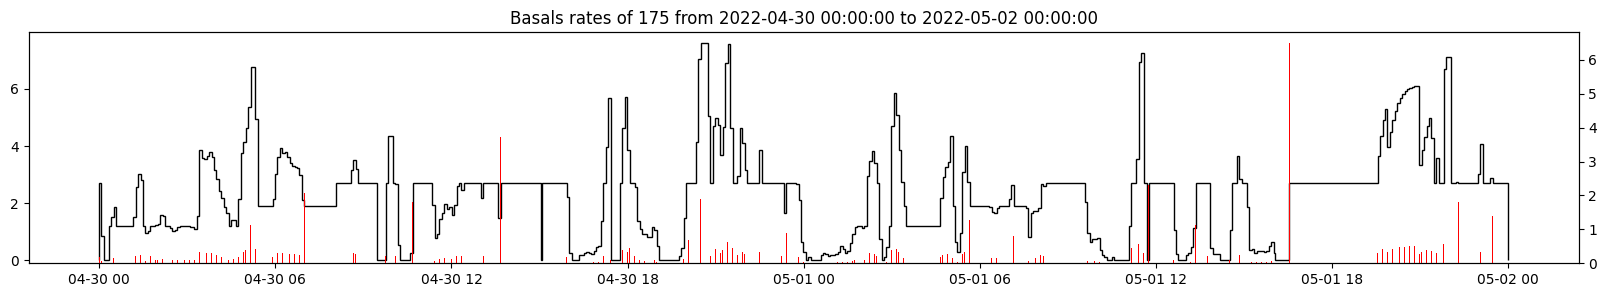

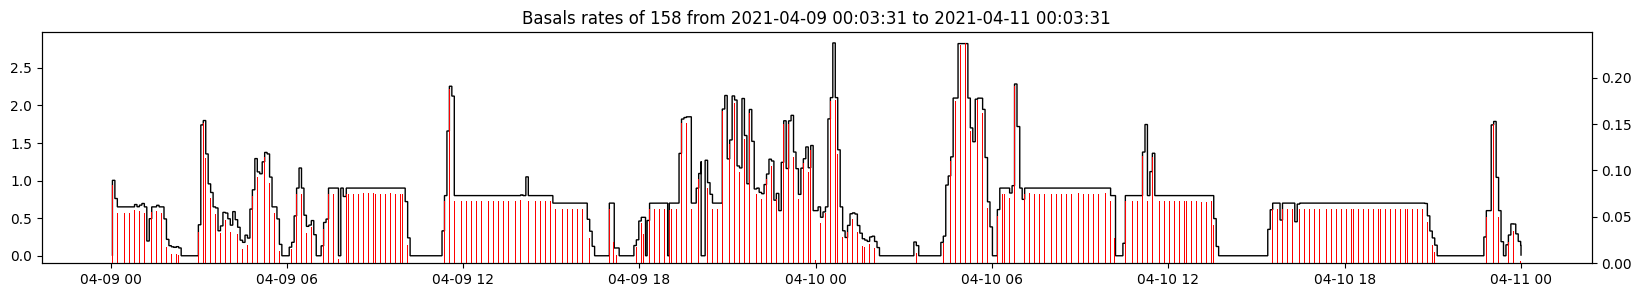

In [43]:
#plot examples for basal flow rates and basal deliveries for 
from src import drawing
from importlib import reload
reload(drawing)

#show an example of a flow rate and a basal within the same subject
patient_ids = facm.loc[~facm.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])].USUBJID.sample(2).values
for patient_id in patient_ids:

    sub = facm.loc[(facm.USUBJID==patient_id)&(facm.FATEST.notna())].sort_values('FADTC')
    start = sub.FADTC.min()+timedelta(days=1)
    dur = timedelta(hours=48)
    sub = sub.loc[(sub.FADTC>=start)&(sub.FADTC<=start+dur)]

    sub_flow_rates = sub.loc[sub.FATEST=='BASAL FLOW RATE']
    sub_basals = sub.loc[sub.FATEST=='BASAL INSULIN']
    
    #draw basal delivery rates
    plt.figure(figsize=(20,3)); ax=plt.gca()
    drawing.drawAbsoluteBasalRates(ax,sub_flow_rates.FADTC.values, sub_flow_rates.FAORRES.values,label='U/hr',hatch=None)
    
    #draw individual basal deliveries
    twinx = ax.twinx()
    drawing.drawBoluses(twinx,sub_basals.FADTC, sub_basals.FAORRES,label='U',width=timedelta(minutes=1))
    plt.title(f'Basals rates of {patient_id} from {start} to {start+dur}'); 
    
    # draw Nan deliveries as red xs at zero
    nan_flow_rates = sub_flow_rates.loc[sub_flow_rates.FAORRES.isna()]
    plt.scatter(nan_flow_rates.FADTC, [0]*len(nan_flow_rates), color='red', marker='v', s=100)
    
    # Set ylim to current limits but reduce minimum by 0.1
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0] - 0.1, ylim[1])

    # Save the figure
    file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basal_and_flow_rates'+patient_id+'.png')
    plt.savefig(file)

Above we saw that the NaN values happen in regions where flow rates are 0. Let's look at a few examples.

**Observations:**  
- The basal deliveries modulrate the basal rate (U/hr)
- No NaN Values in T1DEXip

##### Comparing basal flow rate and deliveries sums

In [46]:
#compare sums of total basal doses between deliveries and flow rates

pump_rows = facm.loc[~(facm.TRTMNT=='MDI')].copy()
pump_rows['day'] = pump_rows.FADTC.dt.date

# Check if for all Basal flow rates, there is a duration
print(f"For {100*pump_rows.loc[facm.FATEST=='BASAL FLOW RATE'].FADUR.notna().mean():.2f}% of flow rates (pump only) rows have a duration")

#calculate daily basal delivery as the product of duration and flow rate
flow_rates_with_dur = pump_rows.loc[pump_rows.FATEST=='BASAL FLOW RATE'].dropna(subset=['FADUR'])
pump_rows['basal_rate'] =  flow_rates_with_dur.FAORRES * flow_rates_with_dur.FADUR.dt.total_seconds()/3600
daily_flowrate_sums = pump_rows.groupby(['USUBJID','day'])['basal_rate'].sum(min_count=1)

#calculate daily basal delivery as the sum of all deliveries
daily_delivery_sums = pump_rows.loc[pump_rows.FATEST=='BASAL INSULIN'].groupby(['USUBJID','day'])['FAORRES'].sum(min_count=1)

#compare the daily deliveries
print(f'Total Daily Basal doses are {daily_flowrate_sums.sum():.2f}U (flow rates) {daily_delivery_sums.sum():.2f}U (deliveries)')
print(f"The error is:")
display((daily_flowrate_sums-daily_delivery_sums).agg(['mean','std','min','max','sum']))

For 100.00% of flow rates (pump only) rows have a duration
Total Daily Basal doses are 49652.72U (flow rates) 49747.42U (deliveries)
The error is:


mean    -0.032853
std      0.680985
min    -22.700265
max      0.028421
sum    -68.695749
dtype: float64

### ... summary
- Basal deliveries and flow rates are almost identical (a little more than in T1DExi)

### MDI vs. Pump Doses (NaN Basals Flows)
1. Check: Are BASAL FLOW RATES always zero in MDI? 
2. Check: Are BASAL in MDI much larger than in Pump?
3. Check: all BASAL in MDI injections?

In [50]:
#Where does the data sit in MDI
print("Which MDI columns contain valid values?")
# def isna(x):
#     return x.isna().sum()
r = facm.loc[facm.TRTMNT=='MDI'].groupby(['FATEST','FAORRESU'])[['FADTC','FADUR','INSSTYPE','INSNMBOL','INSEXBOL','FAORRES']].agg(['count'])
display(r)

display(facm.loc[facm.TRTMNT=='MDI'].FATEST.value_counts())

Which MDI columns contain valid values?


,,FADTC,FADUR,INSSTYPE,INSNMBOL,INSEXBOL,FAORRES
,,count,count,count,count,count,count
FATEST,FAORRESU,,,,,,
BASAL INSULIN,U,425,0,0,0,0,425
BOLUS INSULIN,U,1377,0,94,94,0,1377


FATEST
BOLUS INSULIN    1377
BASAL INSULIN     425
Name: count, dtype: int64

In [51]:
#Check how many BASAL FLOW RATES exists in MDI
mdi_with_flow_rates= facm.loc[(facm.TRTMNT=='MDI') &(facm.FATEST=='BASAL FLOW RATE')]
print(f'There are {len(mdi_with_flow_rates.USUBJID.unique())} MDI patients with flow rates')
print(f" wich are {100*len(mdi_with_flow_rates)/len(facm.loc[(facm.DXTRT=='MULTIPLE DAILY INJECTIONS')]):.2f}% of the MDI data")
print(f" from these, {mdi_with_flow_rates.FAORRES.count()} are not NaN")

There are 0 MDI patients with flow rates
 wich are 0.00% of the MDI data
 from these, 0 are not NaN


- Most MDI data is in FAORRES but not in INSMBOL

#### MDI Basal durations? How often do patients inject?

(-5.0, 72.0)

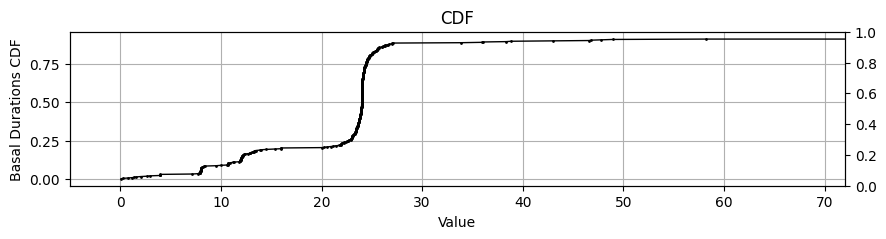

In [53]:
mdi_basal = facm.loc[facm.FATEST.isin(['BASAL INSULIN']) & (facm.DXTRT=='MULTIPLE DAILY INJECTIONS')]

basal_dur = mdi_basal.groupby('USUBJID').FADTC.apply(lambda x: x.diff().dt.total_seconds()/3600)
plt.figure(figsize=(10,2));ax=plt.gca(); twinx = ax.twinx()
cdf.plot_cdf(basal_dur, label='MDI Basal Durations',ax=ax);
ax.set_ylabel('Basal Durations CDF')
ax.set_xlim(-5,72)
#save = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_mdi_basal_durations.png')
#plt.savefig(save)

As we can see there are several groups:
 1. around 0 hours (could be priming doses)
 2. <102h (half day insulin like levimir)
 3. around 24h (1 time injections like glargine)
 4. some around 48 hours (degludec) and possibly missed doses 

 This seems reasonable. While we might miss some doses (either no injection happened or not logged), this seems to be a fair approximation. Further investigation could be done to correlate these fundings based on the basal insulin type.

In [82]:
#show examples for priming doses or duplicated injections

#select a basal with short duration
mdi_basal = mdi_basal.sort_values('FADTC')
repeated_injections = mdi_basal.loc[mdi_basal.FADUR<timedelta(hours=1)]
print(f'There are {len(repeated_injections)} repeated injections in the MDI dataset')


for sample in repeated_injections.itertuples():
    print(sample)
    user = sample.USUBJID
    index = sample.Index

    #show the row and the next one for that patient
    temp = mdi_basal.loc[mdi_basal.USUBJID==user]
    i = temp.index.get_loc(index)
    display(temp.iloc[i:i+2])

There are 3 repeated injections in the MDI dataset
Pandas(Index=318405, USUBJID='443', FATESTCD='INSBASAL', FATEST='BASAL INSULIN', FAOBJ='INSULIN', FACAT='BASAL', FAORRES=18.0, FAORRESU='U', FADTC=Timestamp('2021-07-19 21:45:00'), FADUR=Timedelta('0 days 00:17:00'), INSDVSRC=nan, INSSTYPE=nan, INSNMBOL=nan, INSEXBOL=nan, FAGRPID=3.0, day=datetime.date(2021, 7, 19), DXTRT='MULTIPLE DAILY INJECTIONS', TRTMNT='MDI')


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day,DXTRT,TRTMNT
318405,443,INSBASAL,BASAL INSULIN,INSULIN,BASAL,18.0,U,2021-07-19 21:45:00,0 days 00:17:00,NaN,NaN,NaN,NaN,3.0,2021-07-19,MULTIPLE DAILY INJECTIONS,MDI
318406,443,INSBASAL,BASAL INSULIN,INSULIN,BASAL,10.0,U,2021-07-19 22:02:00,1 days 00:07:00,NaN,NaN,NaN,NaN,3.0,2021-07-19,MULTIPLE DAILY INJECTIONS,MDI


Pandas(Index=200431, USUBJID='317', FATESTCD='INSBASAL', FATEST='BASAL INSULIN', FAOBJ='INSULIN', FACAT='BASAL', FAORRES=12.0, FAORRESU='U', FADTC=Timestamp('2022-03-23 20:24:29'), FADUR=Timedelta('0 days 00:05:31'), INSDVSRC=nan, INSSTYPE=nan, INSNMBOL=nan, INSEXBOL=nan, FAGRPID=3.0, day=datetime.date(2022, 3, 23), DXTRT='MULTIPLE DAILY INJECTIONS', TRTMNT='MDI')


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day,DXTRT,TRTMNT
200431,317,INSBASAL,BASAL INSULIN,INSULIN,BASAL,12.0,U,2022-03-23 20:24:29,0 days 00:05:31,NaN,NaN,NaN,NaN,3.0,2022-03-23,MULTIPLE DAILY INJECTIONS,MDI
200432,317,INSBASAL,BASAL INSULIN,INSULIN,BASAL,11.0,U,2022-03-23 20:30:00,1 days 00:00:00,NaN,NaN,NaN,NaN,3.0,2022-03-23,MULTIPLE DAILY INJECTIONS,MDI


Pandas(Index=22591, USUBJID='125', FATESTCD='INSBASAL', FATEST='BASAL INSULIN', FAOBJ='INSULIN', FACAT='BASAL', FAORRES=14.0, FAORRESU='U', FADTC=Timestamp('2022-06-22 20:42:08'), FADUR=Timedelta('0 days 00:46:52'), INSDVSRC=nan, INSSTYPE=nan, INSNMBOL=nan, INSEXBOL=nan, FAGRPID=3.0, day=datetime.date(2022, 6, 22), DXTRT='MULTIPLE DAILY INJECTIONS', TRTMNT='MDI')


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day,DXTRT,TRTMNT
22591,125,INSBASAL,BASAL INSULIN,INSULIN,BASAL,14.0,U,2022-06-22 20:42:08,0 days 00:46:52,NaN,NaN,NaN,NaN,3.0,2022-06-22,MULTIPLE DAILY INJECTIONS,MDI
22592,125,INSBASAL,BASAL INSULIN,INSULIN,BASAL,14.0,U,2022-06-22 21:29:00,1 days 00:01:00,NaN,NaN,NaN,NaN,3.0,2022-06-22,MULTIPLE DAILY INJECTIONS,MDI


**Observation**: 
- No MDI Flow rates
- 3 repeated injections (probably split or recorded twice)

#### MDI vs. Pump Doses

In [83]:
#calculate average total daily bolus and basal dose per group

facm['day'] = facm.FADTC.dt.date

#sum per FATEST type
#remove BASAL FLOW RATES from the dataset assuming that they reflect the same as the sum of BASAL INSULIN deliveries for Pump users (they are Nan for MDI any way)
temp = facm.loc[facm.FATEST!='BASAL FLOW RATE']
r = temp.groupby(['TRTMNT','FATEST','USUBJID','day'])[['FAORRES']].agg('sum')
#bolus, basal per day
#display(r.sample(3))

#sum per day
daily_sum = r.sum(axis=1)
#display(daily_sum.sample(3))

#mean basal/bolus
group_mean = daily_sum.groupby(level=[0, 1]).mean()
display(group_mean)

TRTMNT  FATEST       
AID     BASAL INSULIN    25.201552
        BOLUS INSULIN    35.068908
CSII    BASAL INSULIN    20.835565
        BOLUS INSULIN    30.330499
MDI     BASAL INSULIN    24.947154
        BOLUS INSULIN    27.818182
dtype: float64

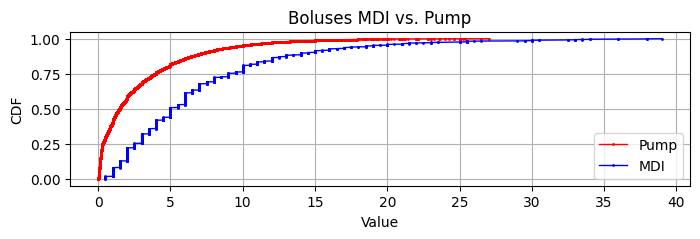

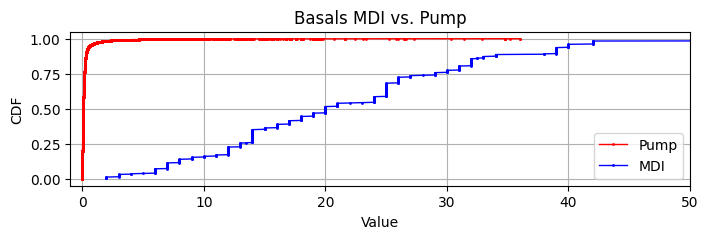

In [84]:
#let's compare the dose sizes
daily_sum_patient = daily_sum.groupby(level=[0,1,2]).mean()
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~(facm.TRTMNT=='MDI'))&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[((facm.TRTMNT=='MDI'))&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')

file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_mdi_vs_pump_bolus_doses.png')
plt.savefig(file)


ax.legend(); ax.set_title('Boluses MDI vs. Pump')
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~(facm.TRTMNT=='MDI'))&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[(facm.TRTMNT=='MDI')&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')
ax.legend(); ax.set_title('Basals MDI vs. Pump');ax.set_xlim(-1,50)

file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_mdi_vs_pump_basal_doses.png')
plt.savefig(file)


### ... summary
- All BASAL in MDI are of much larger value (indicating injections)

### Bolus Columns

We know that insulin boluses can end up in FAORRES but also in INSNMBOL (normal boluses) and INSEXBOL (extended boluses).

The expectation is that FAORRES carries the sum of the INMBOL and INSEXBOL.  
Can we rely on this or do some boluses not end up in here?

In [105]:
#How many of the 3 columns INSEXBOL INSNMBOL FAORRES carry values?
print('Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES')

temp = facm.loc[(facm.FATEST=='BOLUS INSULIN') & (facm.TRTMNT!='MDI')]
print('\nPUMP:')
display(temp[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

print('\nMDI:')
temp = facm.loc[(facm.FATEST=='BOLUS INSULIN') & (facm.TRTMNT=='MDI')]
display(temp[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES

PUMP:


1     7047
2    18858
3      476
Name: count, dtype: int64


MDI:


1    1283
2      94
Name: count, dtype: int64

In [111]:
#check for Rows with only 1 value
bolus_rows = facm.loc[(facm.FATEST=='BOLUS INSULIN') ]
for num_vals in [1,2,3]:
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    print(f'{100*len(temp)/len(bolus_rows):.2f}% of rows have {num_vals} columns with values')
    display(temp[['INSEXBOL','INSNMBOL','FAORRES']].count())

30.01% of rows have 1 columns with values


INSEXBOL       0
INSNMBOL       0
FAORRES     8330
dtype: int64

68.28% of rows have 2 columns with values


INSEXBOL       61
INSNMBOL    18891
FAORRES     18952
dtype: int64

1.71% of rows have 3 columns with values


INSEXBOL    476
INSNMBOL    476
FAORRES     476
dtype: int64

In [112]:
#check breakdown of source and insulin types
for num_vals in [1,2,3]:
    print(f'\n\nRows with {num_vals} columns carrying values: ..')
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    #display(temp.FATEST.value_counts())
    display(temp.value_counts(['FATEST','INSDVSRC','INSSTYPE'],dropna=False,sort=False))



Rows with 1 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE
BOLUS INSULIN  Pump      normal      5272
               NaN       NaN         3058
Name: count, dtype: int64



Rows with 2 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE 
BOLUS INSULIN  Pump      automated     5826
                         normal       13065
                         square          61
Name: count, dtype: int64



Rows with 3 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE   
BOLUS INSULIN  Pump      dual/square    476
Name: count, dtype: int64

In [ ]:
#Let's check if the sums match if there is at least one other value in the other columns
temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) > 1].copy()
temp = temp[['INSEXBOL','INSNMBOL','FAORRES']].fillna(0) # this makes sure the sum does not result in NaN if only ISNMBOL or INSEXBOL has a value
r = temp.FAORRES - (temp.INSEXBOL+temp.INSNMBOL)
print(r.agg(['count','mean','std','min','max','sum']))

count    19428.000000
mean         0.000001
std          0.000159
min         -0.000490
max          0.000500
sum          0.020210
dtype: float64


Yes, they match exactly. 
Last thought: could the rows that have only values in FAORRES be duplicated reports?

In [109]:
#check if there are any boluses reported multiple times. Since we know that FAORRESS always contians the sum, we need to check for duplicates on that column
print(f"{bolus_rows.duplicated(subset=['USUBJID','FADTC','FAORRES']).sum()} duplicated boluses")

0 duplicated boluses


### ... summary

Same as in T1DEXI:
- faorres always contains a value (total dose)
- often these are split into the other two columns INSEXBOL or INSMBOL however not always!
-  Many boluses don't end up in the INMBOL and INSEXBOL columns
  - then only FAORRES contains a value
  - the duration for these boluses is always Nan
  - close to 100% are normal boluses (based on instype) 
    - (only 2 square part and 46 combination whatever those are)
- There are no duplicated boluses

In [113]:
#assign FAORRES values to INSNMBOL if there are no values in INSMBOL and INSEXBOL
facm.loc[(facm.FATEST=='BOLUS INSULIN') & facm[['INSEXBOL','INSNMBOL']].isna().all(axis=1),'INSMNBL'] = facm.FAORRES

## Open Questions to answer
Baed on the script analysis, we found more inconsistencies that we need to check before moving forward.

- Basal Overlaps: How should we deal with them?
- Are there differences between pumps?
- How should suspends be treated?

### Basal Overlaps
We see that basal overlaps are removed. 
  - How do they remove basal overlaps? 
  - Why do these occur at all?
  - How often do they occur?

In [114]:
#identify overlapping basal flow rates (here, we check only if one of the two next rows overlap)

def overlaps(df):
    assert df.FADTC.is_monotonic_increasing
    end = df.FADTC + df.FADUR  
    next = df.FADTC.shift(-1)
    overlap = (next < end)
    return overlap

flow_rows = facm.loc[facm.FATEST=='BASAL FLOW RATE'].copy()
flow_rows['overlaps'] = flow_rows.groupby('USUBJID').apply(overlaps, include_groups=False).droplevel(0)
#flow_rows['END'] = flow_rows.FADTC + flow_rows.FADUR

print(f'{flow_rows.overlaps.sum()} overlapping basal flow rates')
#how often does it happen?
print(f'{flow_rows.overlaps.mean()*100:.2f}% the next flow rate starts before the previous ends')
#which pumps are affected?
flow_rows.loc[flow_rows.overlaps].DXTRT.value_counts()

684 overlapping basal flow rates
0.31% the next flow rate starts before the previous ends


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             606
INSULET OMNIPOD DASH                          74
TANDEM T:SLIM X2 WITH BASAL IQ                 2
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM      2
Name: count, dtype: int64

In [115]:
#show examples
def display_neighboring_rows_of_row(df, row,iprev,inext):
    iloc = df.index.get_loc(row.Index)
    display(df.iloc[iloc-iprev:iloc+inext+1])

sample = flow_rows.loc[flow_rows.overlaps].sample(1)

for row in sample.itertuples():
    display_neighboring_rows_of_row(flow_rows[['USUBJID','FATEST','FAORRES','FADTC','FADUR']], row, 0,2)

,USUBJID,FATEST,FAORRES,FADTC,FADUR
103082,226,BASAL FLOW RATE,2.4,2021-02-11 09:17:33,0 days 00:05:02
103083,226,BASAL FLOW RATE,2.4,2021-02-11 09:20:53,0 days 00:05:01
103084,226,BASAL FLOW RATE,2.4,2021-02-11 09:22:35,0 days 00:05:01


### ... summary
As in T1DEXi, basal overlaps happen extremely rarely. 

### Insulin types

Percentage of suspend basal insulin by device


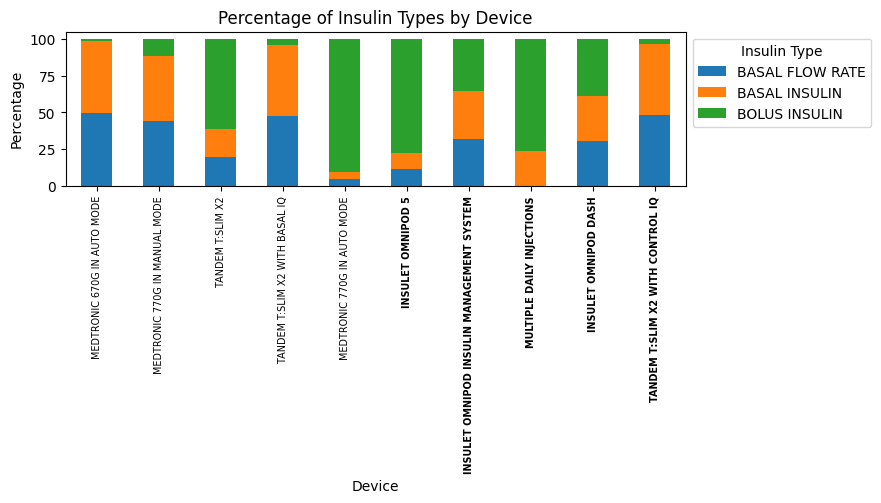

In [ ]:
# insulin type per device
#pump_rows = facm.loc[~(facm.TRTMNT=='MDI')].copy()
r = facm.value_counts(['DXTRT','FATEST'],sort=False)
print("Percentage of suspend basal insulin by device")
r = r.unstack(level=1)
r = 100*r.div(r.sum(axis=1), axis=0)

#sort by number of patients per platform
patients_per_platform = facm.groupby('DXTRT').USUBJID.nunique().sort_values()
r = r.loc[patients_per_platform.index]

plt.figure(figsize=(8,2)); ax=plt.gca()
r.plot(kind='bar', stacked=True, ax=ax)
plt.title('Percentage of Insulin Types by Device')
plt.ylabel('Percentage')
plt.xlabel('Device')
plt.legend(title='Insulin Type', loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(fontsize='x-small')

# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')

#save file 
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_insulin_types_by_device.png')
plt.savefig(file)


#### TDDs

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_15578/1027715866.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = facm.groupby(['DXTRT','USUBJID','day']).apply(tdd)


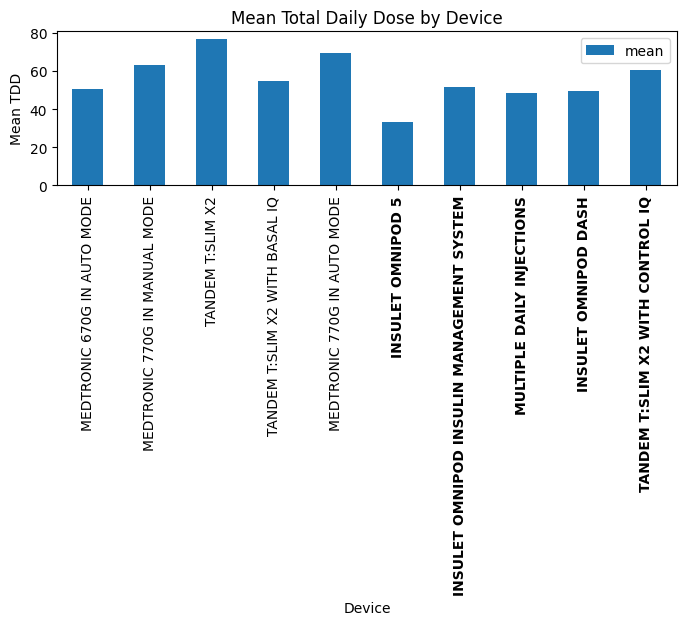

In [140]:
#TDDs
def tdd(df):
    bolus_tdd = df.loc[df.FATEST=='BOLUS INSULIN'].FAORRES.sum()
    basal_tdd = df.loc[df.FATEST=='BASAL INSULIN'].FAORRES.sum()
    return pd.Series({'Bolus TDD':bolus_tdd,'Basal TDD':basal_tdd})
tdds = facm.groupby(['DXTRT','USUBJID','day']).apply(tdd)
mean_tdds_by_pump = tdds.sum(axis=1).groupby('DXTRT').agg(['mean'])

# Sort by the order of patients_per_platform
mean_tdds_by_pump = mean_tdds_by_pump.loc[patients_per_platform.index]
#display(mean_tdds_by_pump)

#draw as bar char
plt.figure(figsize=(8,2)); ax=plt.gca()
mean_tdds_by_pump.plot(kind='bar',ax=ax)
# draw std
plt.title('Mean Total Daily Dose by Device')
plt.ylabel('Mean TDD')
plt.xlabel('Device')


# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')
plt.show()

#### Inocrrect Pump Labels?

The inconsistency observed above could also indicate incorret labeling of the pumps.
Let's look at the distributions.

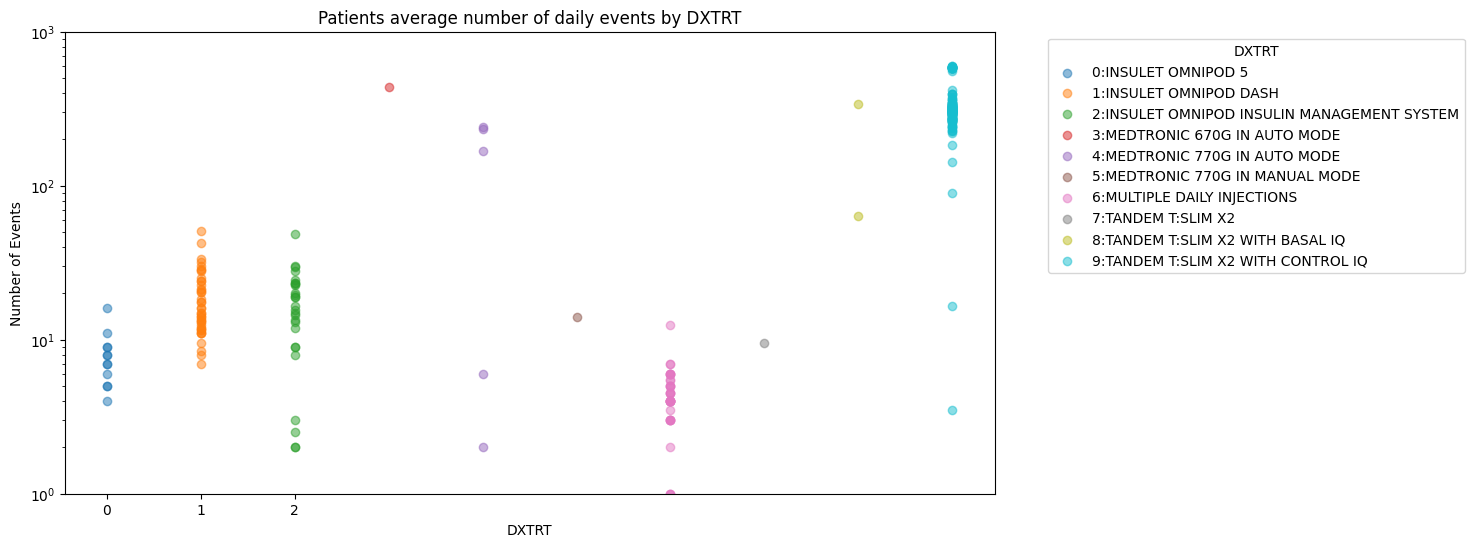

In [205]:
#get average daily event counts per device
num_events = facm.groupby(['TRTMNT', 'DXTRT', 'USUBJID','day']).size()
num_events = num_events.groupby(level=[0,1,2]).median()
plt.figure(figsize=(12, 6))
for i,dxtrt in enumerate(num_events.index.levels[1]):
    subset = num_events.loc[:,dxtrt]
    plt.scatter([dxtrt] * len(subset), subset, label=f'{i}:{dxtrt}',alpha=0.5)

plt.xlabel('DXTRT')
plt.ylabel('Number of Events')
plt.title('Patients average number of daily events by DXTRT')
xticks = np.arange(len(num_events.index.levels[0]))
plt.xticks(xticks, xticks)
plt.legend(title='DXTRT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.ylim(1,1000)

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_daily_events_by_device.png')
plt.savefig(file, bbox_inches='tight')

In contrast to T1DEXi, we see many more pumps that show surprisingly little number of events for AID pumps.

Lets's compare the three AID pumps:

In [219]:
facm.groupby(['TRTMNT','DXTRT']).USUBJID.nunique()

TRTMNT  DXTRT                                    
AID     INSULET OMNIPOD 5                             12
        MEDTRONIC 670G IN AUTO MODE                    1
        MEDTRONIC 770G IN AUTO MODE                    5
        TANDEM T:SLIM X2 WITH BASAL IQ                 1
        TANDEM T:SLIM X2 WITH CONTROL IQ             131
CSII    INSULET OMNIPOD DASH                          42
        INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     27
        MEDTRONIC 770G IN MANUAL MODE                  1
        TANDEM T:SLIM X2                               1
        TANDEM T:SLIM X2 WITH BASAL IQ                 1
MDI     MULTIPLE DAILY INJECTIONS                     37
Name: USUBJID, dtype: int64

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_15578/4114026827.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.set_title('Bolus Amounts'); ax.legend();ax.set_xlim(-1,10)
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_15578/4114026827.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


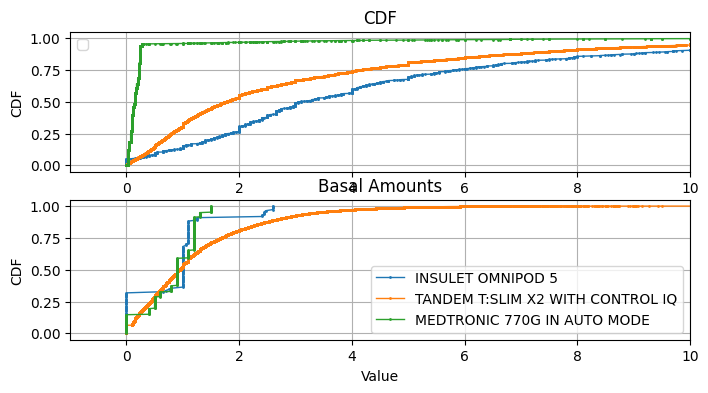

In [228]:
#CDFS for the top 3 AID pumps

pumps= ['INSULET OMNIPOD 5','TANDEM T:SLIM X2 WITH CONTROL IQ','MEDTRONIC 770G IN AUTO MODE']

#boluses
f,AX= plt.subplots(2,1,figsize=(8,4));

ax=AX[0]
for i,pump in enumerate(pumps):
    color = plt.cm.tab10(i)
    temp = facm.loc[facm.DXTRT==pump]
    cdf.plot_cdf(temp.loc[temp.FATEST=='BOLUS INSULIN'].FAORRES,label=pump, color=color,ax=ax)
plt.legend()
ax.set_title('Bolus Amounts'); ax.legend();ax.set_xlim(-1,10)

#basals
ax=AX[1]
for i,pump in enumerate(['INSULET OMNIPOD 5','TANDEM T:SLIM X2 WITH CONTROL IQ','MEDTRONIC 770G IN AUTO MODE']):
    color = plt.cm.tab10(i)
    temp = facm.loc[facm.DXTRT==pump]
    cdf.plot_cdf(temp.loc[temp.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,label=pump, color=color)
ax.set_title('Basal Amounts'); ax.legend();ax.set_xlim(-1,10)
plt.legend()

# save figure
#file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_p_bolus_amounts_AID_pumps.png')
#plt.savefig(file)


It looks like only the Tandem T:SLIM X2 with control IQ was really running in AID mode

### Suspends?
Now, we want to check how to deal with suspend events.

We will look at how the suspend events look in context by plotting the surrounding data.

Percentage of basal suspends


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_15578/2720880989.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = facm.groupby('DXTRT').apply(lambda x: 100*x.INSSTYPE.str.contains('suspend', na=False).sum()/(x.FACAT=='BASAL').sum())#.sort_values('INSSTYPE',ascending=False)


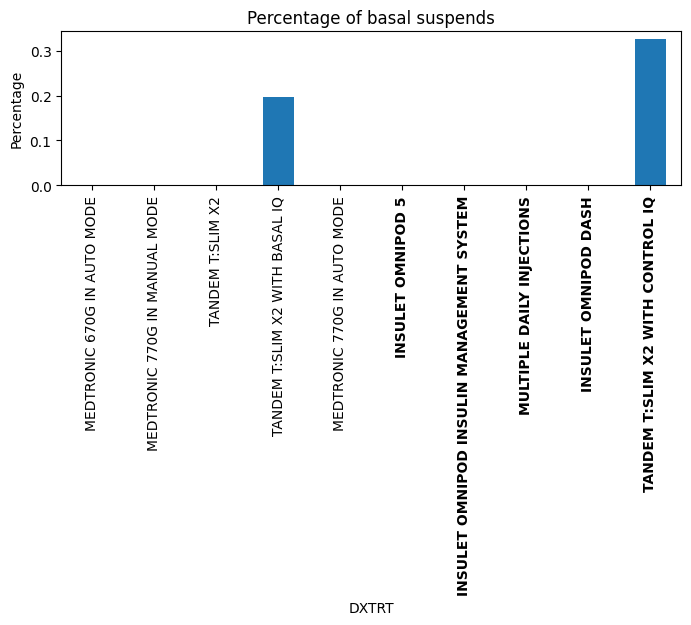

In [236]:
#suspends
#pump_rows = facm.loc[facm.FACAT=='BASAL'].copy()
r = facm.groupby('DXTRT').apply(lambda x: 100*x.INSSTYPE.str.contains('suspend', na=False).sum()/(x.FACAT=='BASAL').sum())#.sort_values('INSSTYPE',ascending=False)

print("Percentage of basal suspends")

#sort by number of patients per platform
r  = r.loc[patients_per_platform.index]

plt.figure(figsize=(8,2)); ax=plt.gca()
r.plot(kind='bar', legend=False,ax=ax)
plt.ylabel('Percentage')
plt.title('Percentage of basal suspends')


# Make the font bold for the last five x-tick labels
xticks = ax.get_xticklabels()
for label in xticks[-5:]:
    label.set_fontweight('bold')

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_basal_suspends_by_device.png')
plt.savefig(file, bbox_inches='tight')

In [240]:
#do we have suspends in deliveries and flow rates?
print('FATEST types for suspend rows')
suspend_rows = facm.loc[facm.INSSTYPE.str.contains('suspend',na=False)]
display(suspend_rows.value_counts(['FATEST','INSSTYPE'],sort=False))

#what are the values for suspends?
print('Values for suspends')
suspend_rows.value_counts(subset=['FATEST','FAORRES'],dropna=False)

FATEST types for suspend rows


FATEST         INSSTYPE
BASAL INSULIN  suspend     1392
Name: count, dtype: int64

Values for suspends


FATEST         FAORRES
BASAL INSULIN  0.0        1392
Name: count, dtype: int64

,FATEST,INSSTYPE,FADTC,FADUR,FAORRES
221739,BASAL FLOW RATE,NaN,2020-11-27 07:56:42,0 days 00:04:59,0.482
221740,BASAL FLOW RATE,NaN,2020-11-27 08:01:41,0 days 00:04:20,0.450
221741,BASAL FLOW RATE,NaN,2020-11-27 08:06:01,0 days 00:08:34,0.000
221742,BASAL FLOW RATE,NaN,2020-11-27 08:14:35,0 days 00:39:55,0.450
222957,BASAL INSULIN,automated,2020-11-27 07:56:42,0 days 00:04:59,0.040
222958,BASAL INSULIN,automated,2020-11-27 08:01:41,0 days 00:04:20,0.033
222959,BASAL INSULIN,suspend,2020-11-27 08:06:01,0 days 00:08:34,0.000
222960,BASAL INSULIN,automated,2020-11-27 08:14:35,0 days 00:39:55,0.299


Text(0.5, 0.98, 'Basal for 350 around 2020-11-27 08:06:01')

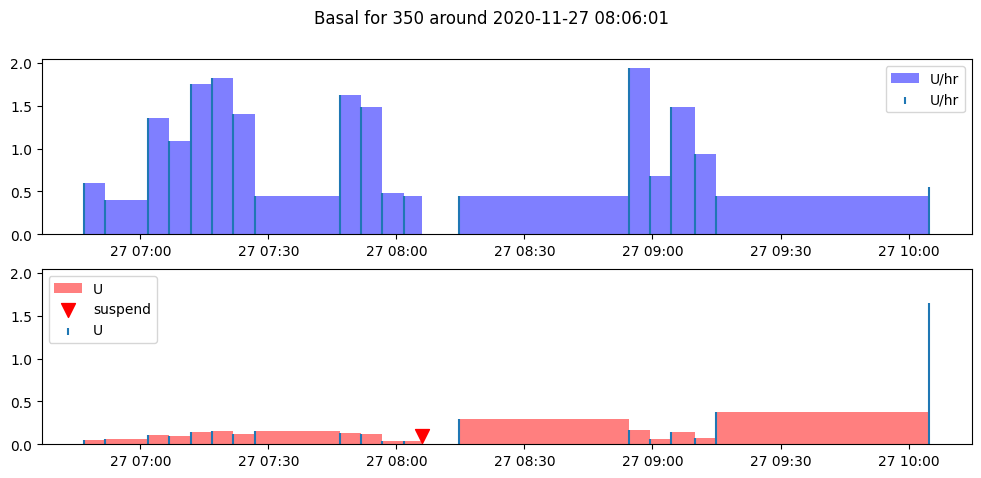

In [245]:
#draw basal and suspend events

sample = suspend_rows.sample(1)

subject = sample.USUBJID.values[0]
datetime = pd.to_datetime(sample.FADTC.values[0])
window = timedelta(hours=4)

context = facm.loc[(facm.USUBJID==subject) & (facm.FACAT == 'BASAL') & (facm.FADTC >= (datetime-window)) & (facm.FADTC<=(datetime+window))].sort_values('FADTC')

#plt.figure(figsize=(20,4)); ax=plt.gca(); twinx = ax.twinx()
fig, AX = plt.subplots(2,1,figsize=(12, 5),sharey=True)
ax=AX[0]; twinx = AX[1]

#draw flow rates
temp = context.loc[context.FATEST=='BASAL FLOW RATE']
drawing.drawBasal(ax,temp.FADTC, temp.FAORRES,label='U/hr')

# draw individual basal deliveries
temp = context.loc[context.FATEST=='BASAL INSULIN']
drawing.drawBasal(twinx,temp.FADTC, temp.FAORRES,label='U',color='red')

#add suspend markers
temp = temp.loc[temp.INSSTYPE.str.contains('suspend',na=False)]
twinx.scatter(temp.FADTC, [0.1]*len(temp), color='red', marker='v', s=100,label='suspend')
ax.legend(); twinx.legend()

#show the events before and after the suspend
iloc = context.index.get_loc(sample.index[0])
display(context.iloc[iloc-4:iloc+4][['FATEST','INSSTYPE','FADTC','FADUR','FAORRES']].sort_values(['FATEST','FADTC']))
plt.suptitle(f'Basal for {subject} around {datetime}')

# save figure
#file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_suspend_example.png')
#plt.savefig(file)

### ... summary
Again, basal insulin and flow rates already integrate suspends.

Hpwever, in contrast to T1DEXi
- suspend events are all zero values, and no NaNs
- Only 2 pumps have suspend events

Therefore, no NaN values need to be filled with zeros

### Duplicates
we did see that often there are duplicated rows (in basal also with different durations altnerating between 0 and a bigger value). Let;s check how to get rid of them
#inspect duplicates

In [250]:
#inspect duplicates
dup_rows = facm.loc[facm.duplicated(subset=['USUBJID','FADTC','FATEST'],keep=False)]
print(f"{len(dup_rows)} rows ({100*len(dup_rows)/len(facm):.5f})% of rows are duplicates")

#type counts
display(dup_rows.FATEST.value_counts())
display(dup_rows[['FADTC','FADUR','FAORRES','FATEST','INSSTYPE']].sort_values('FADTC'))

8 rows (0.00172)% of rows are duplicates


FATEST
BASAL FLOW RATE    4
BASAL INSULIN      4
Name: count, dtype: int64

,FADTC,FADUR,FAORRES,FATEST,INSSTYPE
338471,2022-01-10,0 days 00:00:00,0.570,BASAL FLOW RATE,NaN
338472,2022-01-10,0 days 00:20:21,0.750,BASAL FLOW RATE,NaN
338638,2022-01-10,0 days 00:00:00,0.000,BASAL INSULIN,temp
338639,2022-01-10,0 days 00:20:21,0.254,BASAL INSULIN,scheduled
338611,2022-01-18,0 days 00:00:00,1.310,BASAL FLOW RATE,NaN
338612,2022-01-18,0 days 02:30:00,0.750,BASAL FLOW RATE,NaN
338778,2022-01-18,0 days 00:00:00,0.000,BASAL INSULIN,temp
338779,2022-01-18,0 days 02:30:00,1.875,BASAL INSULIN,scheduled


In [252]:
#show examples for the basal flow rates

#let's focus on basal flow rates
#dup_basal_flows = dup_rows.loc[dup_rows.FATEST=='BASAL FLOW RATE']
row = dup_rows.sample()

subject = row.USUBJID.values[0]
date = row.FADTC.dt.date.values[0]
index = row.index[0]
print(index)

#display rows surrounding the duplicate
context = facm.loc[(facm.USUBJID==subject) & (facm.FADTC.dt.date == date) & (facm.FACAT=='BASAL')].sort_values('FADTC')
i = context.index.get_loc(index)
display(context.iloc[i-3:i+4])

338778


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,FAGRPID,day,DXTRT,TRTMNT,INSMNBL
338611,467,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.310,U/hr,2022-01-18 00:00:00,0 days 00:00:00,NaN,NaN,NaN,NaN,2.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338612,467,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.750,U/hr,2022-01-18 00:00:00,0 days 02:30:00,NaN,NaN,NaN,NaN,2.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338779,467,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.875,U,2022-01-18 00:00:00,0 days 02:30:00,Pump,scheduled,NaN,NaN,1.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338778,467,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2022-01-18 00:00:00,0 days 00:00:00,Pump,temp,NaN,NaN,1.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338613,467,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.650,U/hr,2022-01-18 02:30:00,0 days 01:41:38,NaN,NaN,NaN,NaN,2.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338780,467,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.101,U,2022-01-18 02:30:00,0 days 01:41:38,Pump,scheduled,NaN,NaN,1.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN
338781,467,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.911,U,2022-01-18 04:11:38,0 days 00:48:22,Pump,temp,NaN,NaN,1.0,2022-01-18,INSULET OMNIPOD DASH,CSII,NaN


### ... summary
 Even less temporal duplixates than in T1DExi
  - No Bolus duplicates
How to deal with duplicates?
 - Use the row with the maximum duration

### Corrupt data?
Checking distributions to spot outliers

Number of events for patients to remove


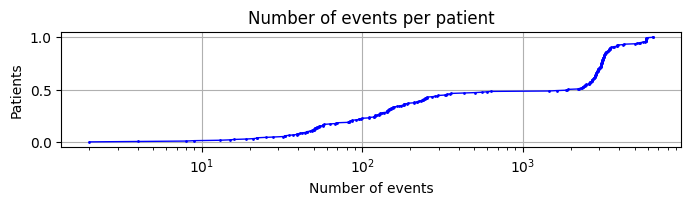

In [255]:
#draw cdf of number of events
plt.figure(figsize=(8,1.5)); ax=plt.gca()
print('Number of events for patients to remove')
num_events_overall = facm.groupby('USUBJID').size()

cdf.plot_cdf(num_events_overall, ax=ax,color='blue',label='all')
plt.title('Number of events per patient'); plt.xlabel('Number of events'); plt.ylabel('Patients')
plt.xscale('log')

# save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_number_of_events_per_patient.png')
plt.savefig(file, bbox_inches='tight')

The daily maximum gaps are not particularly large for the users to be removed. 

Number of days for patients to remove


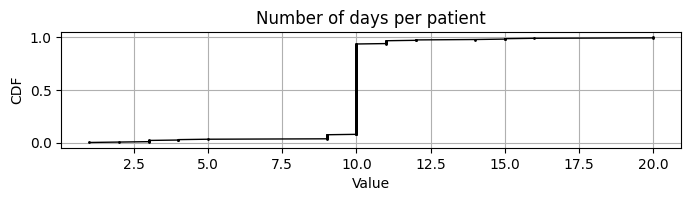

In [ ]:
#cdf: number of days per patient
plt.figure(figsize=(8,1.5)); ax=plt.gca()
print('Number of days for patients to remove')
num_days = facm.groupby(['USUBJID']).day.nunique()

#draw distribution 
cdf.plot_cdf(num_days,ax=ax)
plt.title('Number of days per patient')


- T1DExip, also some patients have mych less datapoints due to less number of days than study duration (<10>)

#### TDD distributions

Total Daily Dose for patients to remove


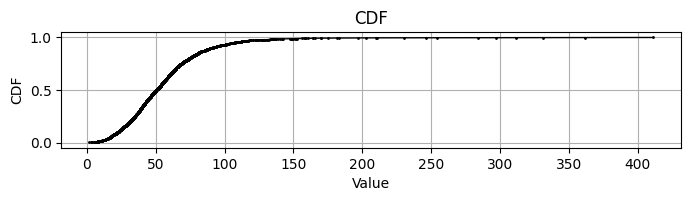

In [314]:
#tdd distribution
plt.figure(figsize=(8,1.5)); ax=plt.gca()

print('Total Daily Dose for patients to remove')
cdf.plot_cdf(tdds.sum(axis=1), ax=ax)
#plt.xscale('log')
#save figure
#file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexi_tdd_per_patient.png')
#plt.savefig(file, bbox_inches='tight')

In [328]:
tdds['total']= tdds.sum(axis=1)
tdds.sort_values('total').tail(10)

Bolus TDD  Basal TDD  \
DXTRT                            USUBJID day                                
TANDEM T:SLIM X2 WITH CONTROL IQ 226     2021-02-11     125.28     85.127   
MULTIPLE DAILY INJECTIONS        436     2022-08-09     230.50      0.000   
                                         2022-08-12     176.50     70.000   
                                         2022-08-13     184.00     70.000   
                                         2022-08-06     214.00     70.000   
                                         2022-08-11     227.00     70.000   
                                         2022-08-05     311.50      0.000   
                                         2022-08-10     261.00     70.000   
                                         2022-08-07     291.50     70.000   
                                         2022-08-08     341.00     70.000   

                                                       total  
DXTRT                            USUBJID day                  
TANDEM T:SLIM X2 WITH CONTROL IQ 226     2021-02-11  210.407  
MULTIPLE DAILY INJECTIONS        436     2022-08-09  230.500  
                                         2022-08-12  246.500  
                                         2022-08-13  254.000  
                                         2022-08-06  284.000  
                                         2022-08-11  297.000  
                                         2022-08-05  311.500  
                                         2022-08-10  331.000  
                                         2022-08-07  361.500  
                                         2022-08-08  411.000

,FATEST,FADTC,FAORRES,FADUR
106046,BASAL INSULIN,2021-02-11 00:00:00,0.352,0 days 00:04:15
106047,BASAL INSULIN,2021-02-11 00:01:38,0.022,0 days 00:04:59
106048,BASAL INSULIN,2021-02-11 00:04:15,0.464,0 days 00:05:00
106049,BASAL INSULIN,2021-02-11 00:06:37,0.050,0 days 00:05:01
106050,BASAL INSULIN,2021-02-11 00:09:15,0.466,0 days 00:05:01
...,...,...,...,...
106553,BASAL INSULIN,2021-02-11 23:38:05,0.117,0 days 00:05:02
106554,BASAL INSULIN,2021-02-11 23:43:07,0.156,0 days 00:05:01
106555,BASAL INSULIN,2021-02-11 23:48:08,0.191,0 days 00:04:59
106556,BASAL INSULIN,2021-02-11 23:53:07,0.250,0 days 00:05:02


,FATEST,FAORRES,FADTC,FADUR,time_diff
108340,BOLUS INSULIN,6.870,2021-02-11 08:58:13,NaT,NaT
108341,BOLUS INSULIN,15.080,2021-02-11 10:10:56,NaT,0 days 01:12:43
108342,BOLUS INSULIN,15.080,2021-02-11 10:13:40,NaT,0 days 00:02:44
108343,BOLUS INSULIN,2.500,2021-02-11 10:58:32,NaT,0 days 00:44:52
108344,BOLUS INSULIN,2.500,2021-02-11 11:20:00,NaT,0 days 00:21:28
108345,BOLUS INSULIN,2.500,2021-02-11 11:25:58,NaT,0 days 00:05:58
108346,BOLUS INSULIN,6.030,2021-02-11 11:30:05,NaT,0 days 00:04:07
108347,BOLUS INSULIN,1.000,2021-02-11 11:45:22,NaT,0 days 00:15:17
108348,BOLUS INSULIN,9.250,2021-02-11 11:50:51,NaT,0 days 00:05:29
108349,BOLUS INSULIN,9.250,2021-02-11 11:51:50,NaT,0 days 00:00:59


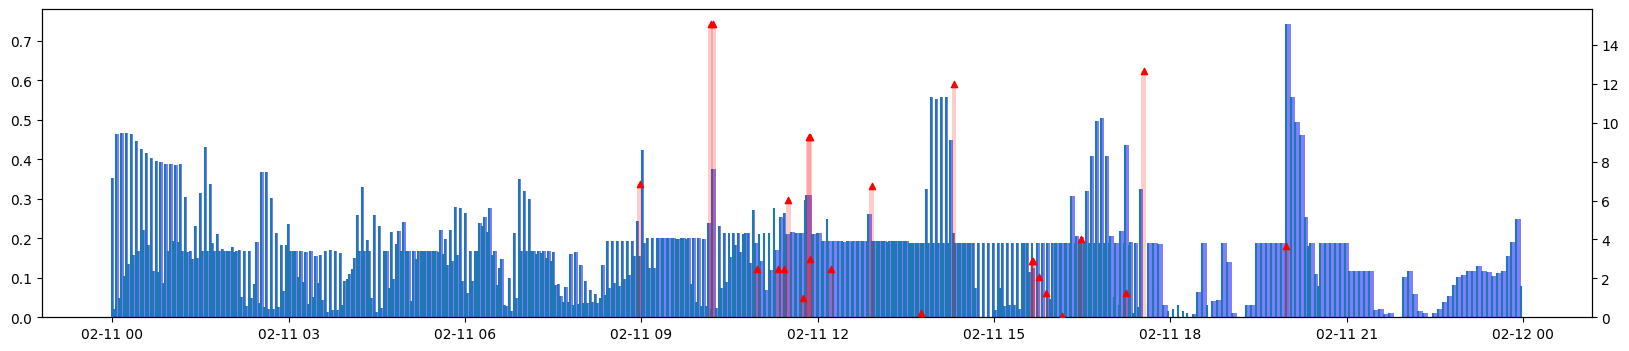

In [338]:
reload(drawing)
#inspect pump patient with highest TDD
temp = facm.loc[(facm.USUBJID=='226') & (facm.day==datetime(2021,2,11).date())]

basals = temp.loc[temp.FATEST=='BASAL INSULIN'].sort_values('FADTC')
display(basals[['FATEST','FADTC','FAORRES','FADUR']])

boluses = temp.loc[temp.FACAT=='BOLUS'][['FATEST','FAORRES','FADTC','FADUR']].sort_values('FADTC')
boluses['time_diff'] = boluses.FADTC.diff()
display(boluses)

plt.figure(figsize=(20,4)); ax=plt.gca(); twinx = ax.twinx()
drawing.drawBasal(ax,basals.FADTC, basals.FAORRES,label='U/hr')
drawing.drawBoluses(twinx,boluses.FADTC, boluses.FAORRES,label='U',width=timedelta(minutes=5),alpha=0.2)
#drawing.drawBoluses(twinx,boluses.FADTC, boluses.FAORRES,label='U',width=timedelta(minutes=1))
##save figure
#file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_basals_317_2019-03-01.png')
#plt.savefig(file, bbox_inches='tight')

,FATEST,FADTC,FAORRES,FADUR
309976,BASAL INSULIN,2022-08-08 10:14:44,70.0,NaT


,FATEST,FAORRES,FADTC,time_diff
310022,BOLUS INSULIN,23.5,2022-08-08 06:19:18,NaT
310023,BOLUS INSULIN,23.5,2022-08-08 06:26:39,0 days 00:07:21
310024,BOLUS INSULIN,20.0,2022-08-08 10:13:38,0 days 03:46:59
310025,BOLUS INSULIN,12.5,2022-08-08 10:13:54,0 days 00:00:16
310026,BOLUS INSULIN,32.5,2022-08-08 10:14:29,0 days 00:00:35
310027,BOLUS INSULIN,32.5,2022-08-08 10:14:52,0 days 00:00:23
310028,BOLUS INSULIN,12.0,2022-08-08 13:53:52,0 days 03:39:00
310029,BOLUS INSULIN,5.5,2022-08-08 15:01:06,0 days 01:07:14
310030,BOLUS INSULIN,17.5,2022-08-08 15:01:17,0 days 00:00:11
310031,BOLUS INSULIN,17.5,2022-08-08 15:01:27,0 days 00:00:10


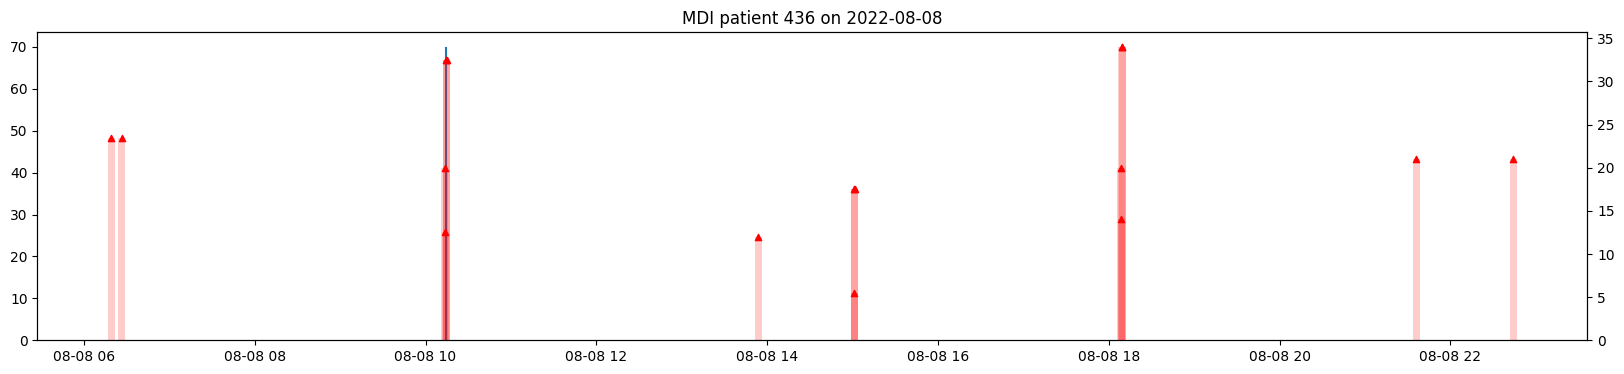

In [442]:
#inspect MDI with with highest TDD
temp = facm.loc[(facm.USUBJID=='436') & (facm.day==datetime(2022,8,8).date())]

basals = temp.loc[temp.FATEST=='BASAL INSULIN'].sort_values('FADTC')
display(basals[['FATEST','FADTC','FAORRES','FADUR']])

boluses = temp.loc[temp.FACAT=='BOLUS'][['FATEST','FAORRES','FADTC']].sort_values('FADTC')
boluses['time_diff'] = boluses.FADTC.diff()
display(boluses)

plt.figure(figsize=(20,4)); ax=plt.gca(); twinx = ax.twinx()
drawing.drawBasal(ax,basals.FADTC, basals.FAORRES,label='U/hr')
drawing.drawBoluses(twinx,boluses.FADTC, boluses.FAORRES,label='U',width=timedelta(minutes=5),alpha=0.2)
plt.title('MDI patient 436 on 2022-08-08')
#save figur
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_basals_436_2022-08-08.png')
plt.savefig(file, bbox_inches='tight')

Pump user: 
- basals durations overlapping

MDI user:
 - a lot of equal boluses in close approximation, maybe split bolus or recorded twice?

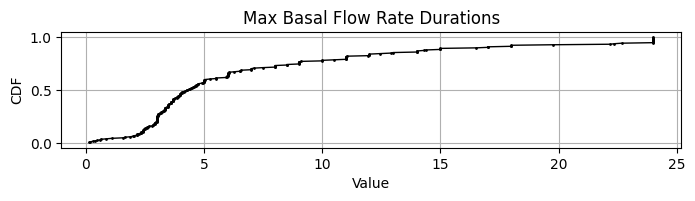

In [444]:
basal_max_durs = facm.loc[(facm.FATEST=='BASAL FLOW RATE')].groupby('USUBJID').FADUR.max().dt.total_seconds()/3600
#display(basal_max_durs.sort_values().tail(10))
plt.figure(figsize=(8,1.5)); ax=plt.gca()
cdf.plot_cdf(basal_max_durs, label='Basal Flow Rate Durations',ax=ax)
plt.title('Max Basal Flow Rate Durations')

#save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_basal_max_durations.png')
plt.savefig(file, bbox_inches='tight')


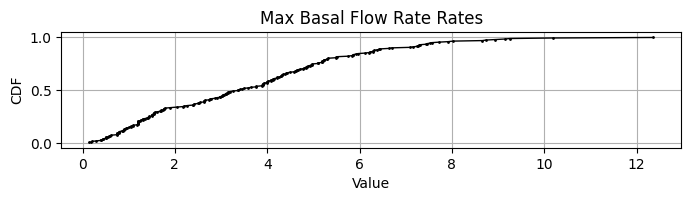

In [443]:
basal_max_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE')].groupby('USUBJID').FAORRES.max()
plt.figure(figsize=(8,1.5)); ax=plt.gca()
cdf.plot_cdf(basal_max_rates, label='Basal Flow Rate Rates',ax=ax)
plt.title('Max Basal Flow Rate Rates')

## save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_basal_max_rates.png')
plt.savefig(file, bbox_inches='tight')

We see that 
- MDI patients with highest TDD appears to have duplicated bolus records 
- Pump users with overlapping basal durations
- Pump patients with long durations but not extreme basal flow rates as in T1DExi

## Glucose Data

Text(0.5, 1.0, 'Number of days equivalent of CGM data per patient')

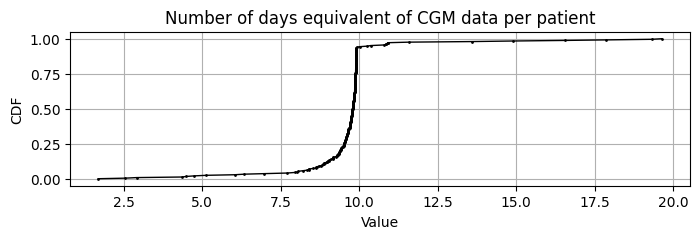

In [372]:
## how many days worth of data do patients have?
day_equivalent_num_cgms = (lb.groupby('USUBJID').size()/(24*12)).sort_values(ascending=False)
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(day_equivalent_num_cgms,ax=ax)
plt.title('Number of days equivalent of CGM data per patient')

0.13 % of the values are below 41
0.58 % of the values are above 400


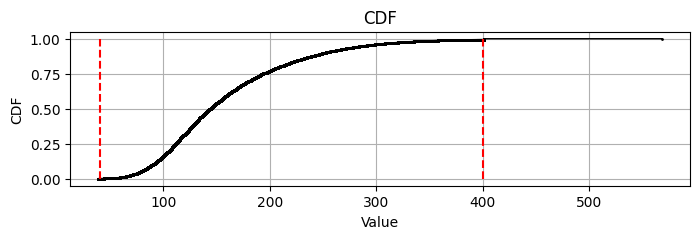

In [374]:
## CGM distribution
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(lb.LBORRES,ax=ax)
print(f'{100*(lb.LBORRES<=41).sum()/len(lb):.2f} % of the values are below 41')
print(f'{100*(lb.LBORRES>=400).sum()/len(lb):.2f} % of the values are above 400')
plt.vlines([41,400],0,1,linestyles='dashed',colors='red')

In [408]:
sample = lb.loc[lb.LBORRES>401]
sample

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT
590311,T1DEXI-P,LB,525,1.0,GLUC,Glucose,CGM,568.0,mg/dL,568,568.0,mg/dL,1.930503e+09,,,,


There are 8 duplicated cgms


,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT
70316,T1DEXI-P,LB,150,2416.0,GLUC,Glucose,76.0,mg/dL,76,76.0,mg/dL,2021-12-04 22:32:48,NaN,NaN,NaN,NaN
70317,T1DEXI-P,LB,150,2417.0,GLUC,Glucose,76.0,mg/dL,76,76.0,mg/dL,2021-12-04 22:32:48,NaN,NaN,NaN,NaN
123732,T1DEXI-P,LB,202,98.0,GLUC,Glucose,127.0,mg/dL,127,127.0,mg/dL,2022-02-02 08:30:34,NaN,NaN,NaN,NaN
123733,T1DEXI-P,LB,202,99.0,GLUC,Glucose,127.0,mg/dL,127,127.0,mg/dL,2022-02-02 08:30:34,NaN,NaN,NaN,NaN


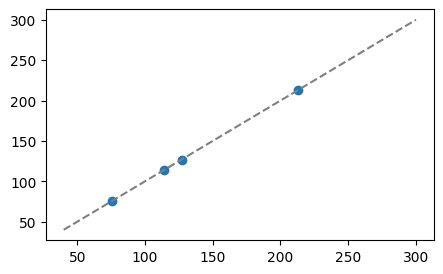

In [401]:
## duplicates
temp = lb.loc[lb.duplicated(subset=['USUBJID','LBDTC'],keep=False)]
print(f"There are {len(temp)} duplicated cgms")
display(temp.head(4))

def get_min_max_duplicates(df,dup_cols,val_col):
    dups = df[df.duplicated(subset=dup_cols, keep=False)]
    results = dups.groupby(dup_cols)[val_col].agg(['min','max'])
    return results

dup_min_max = get_min_max_duplicates(lb,['USUBJID','LBDTC'],'LBORRES')
plt.figure(figsize=(5,3)); ax=plt.gca()
ax.plot([40,300],[40,300], '--', color='gray')
ax.scatter(dup_min_max['min'], dup_min_max['max'])


They are more or less the same, also really few, drop using first

In [402]:
## drop duplicates
lb = lb.drop_duplicates(subset=['USUBJID','LBDTC'],keep='first')

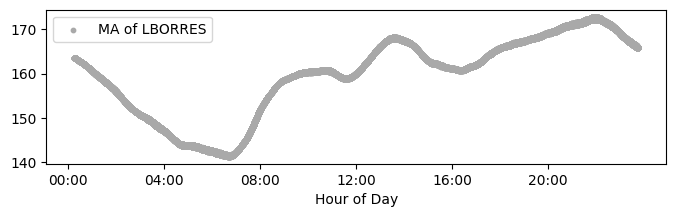

In [445]:
## check for distribution of CGM values
reload(drawing)
plt.figure(figsize=(8,2)); ax=plt.gca()
drawing.drawMovingAverage(ax,lb,'LBDTC','LBORRES')
## save figure
file = os.path.join(os.getcwd(),'..','..','docs','data_sets','assets','t1dexip_cgm_values.png')
plt.savefig(file, bbox_inches='tight')

### Summary Glucose
LB is a very simple dataframe:  
- Glucose is in local time
- all in mg/dl
- No nan values 
- Hb1A1c must be dropped
- one value >401 should be dropped, many values reach 401 (unclear why not 400)
- only a couple temporal duplicates which are dropped (using first) as they correlate perfectly

## Differences T1DExi vs. T1DExip

Overall, the T1DExiP dataset is much cleaner than the T1DExi:
 
 ### Basal Flow rates
 - MDI has no flow rates
 - No NaN FAORRES or NaN duraitons: no need to fill with zeros
 - basal flow rates and basal deliveries are almost identical but overall deivate a little more (70 Units overall)
- There are no extreme basal durations (all below 24h) and no resulting extreme basal flow rates
 - These are likely true Basal rates that are set for a whole day 

### AID Labels
- It looks like only the Tandem T:SLIM X2 with control IQ was really running in AID mode

### Suspends
- suspend events are all zero values, and no NaNs (no need to replace)

### Duplicates
- Basal
    - Same, we see some alternating basals: use maximum duration
- Bolus
    - no complete duplicated bolus rows (instead of 2)
    - Some MDI appear to have (close) duplicated recordings causing high TDDs

### Number of Data Points
- T1DExip, also some patients have much less datapoints due to less number of days than study duration (<10>)
- MDI patients with highest TDD appears to have duplicated bolus records

### Glucose
- there is one sample with a value >401 mg/dl
- some 8 temporal duplicates that can be dropped using first